**Note on BERT Usage**

To meet the project requirement of using BERT, I used the `bert-base-uncased` model to extract embeddings for a randomly sampled subset of 500 reviews from both the training and test sets.

Due to resource constraints and model size, I used the `[CLS]` token embedding as a compact representation of each review. These embeddings were then used to train a Logistic Regression model.

This subset-based approach balances meaningful experimentation with runtime efficiency.

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.




## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')

import spacy

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


import torch
import transformers

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

sns.set_theme() # Will apply the seaborn style

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
try:
    df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    print("Loaded data locally")
except Exception as e_local:
    try:
        df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
        print("Loaded data from the server")
    except Exception as e_server:
        print("Unable to load data from both local and server sources.")

Loaded data locally


In [5]:
df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews[['review', 'pos']].isnull().sum()

review    0
pos       0
dtype: int64

Let's check the number of movies and reviews over years.

## EDA

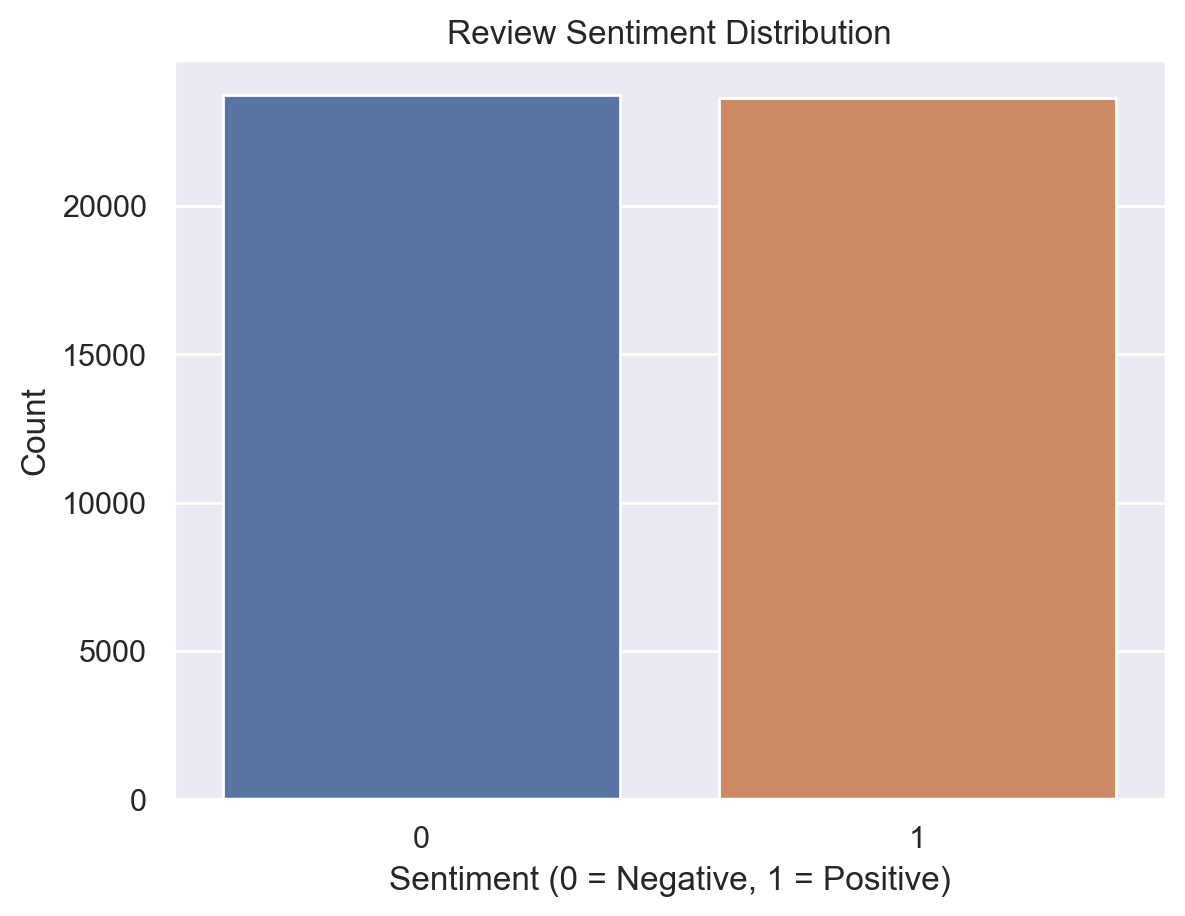

pos
0    0.501046
1    0.498954
Name: proportion, dtype: float64


In [7]:
# Explore how balanced the reviews are
sns.countplot(data=df_reviews, x='pos')
plt.title('Review Sentiment Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

print(df_reviews['pos'].value_counts(normalize=True))

The dataset is balanced, with nearly equal proportions of positive and negative reviews. (This means we won’t need to apply class weighting or resampling techniques to address class imbalance...)

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


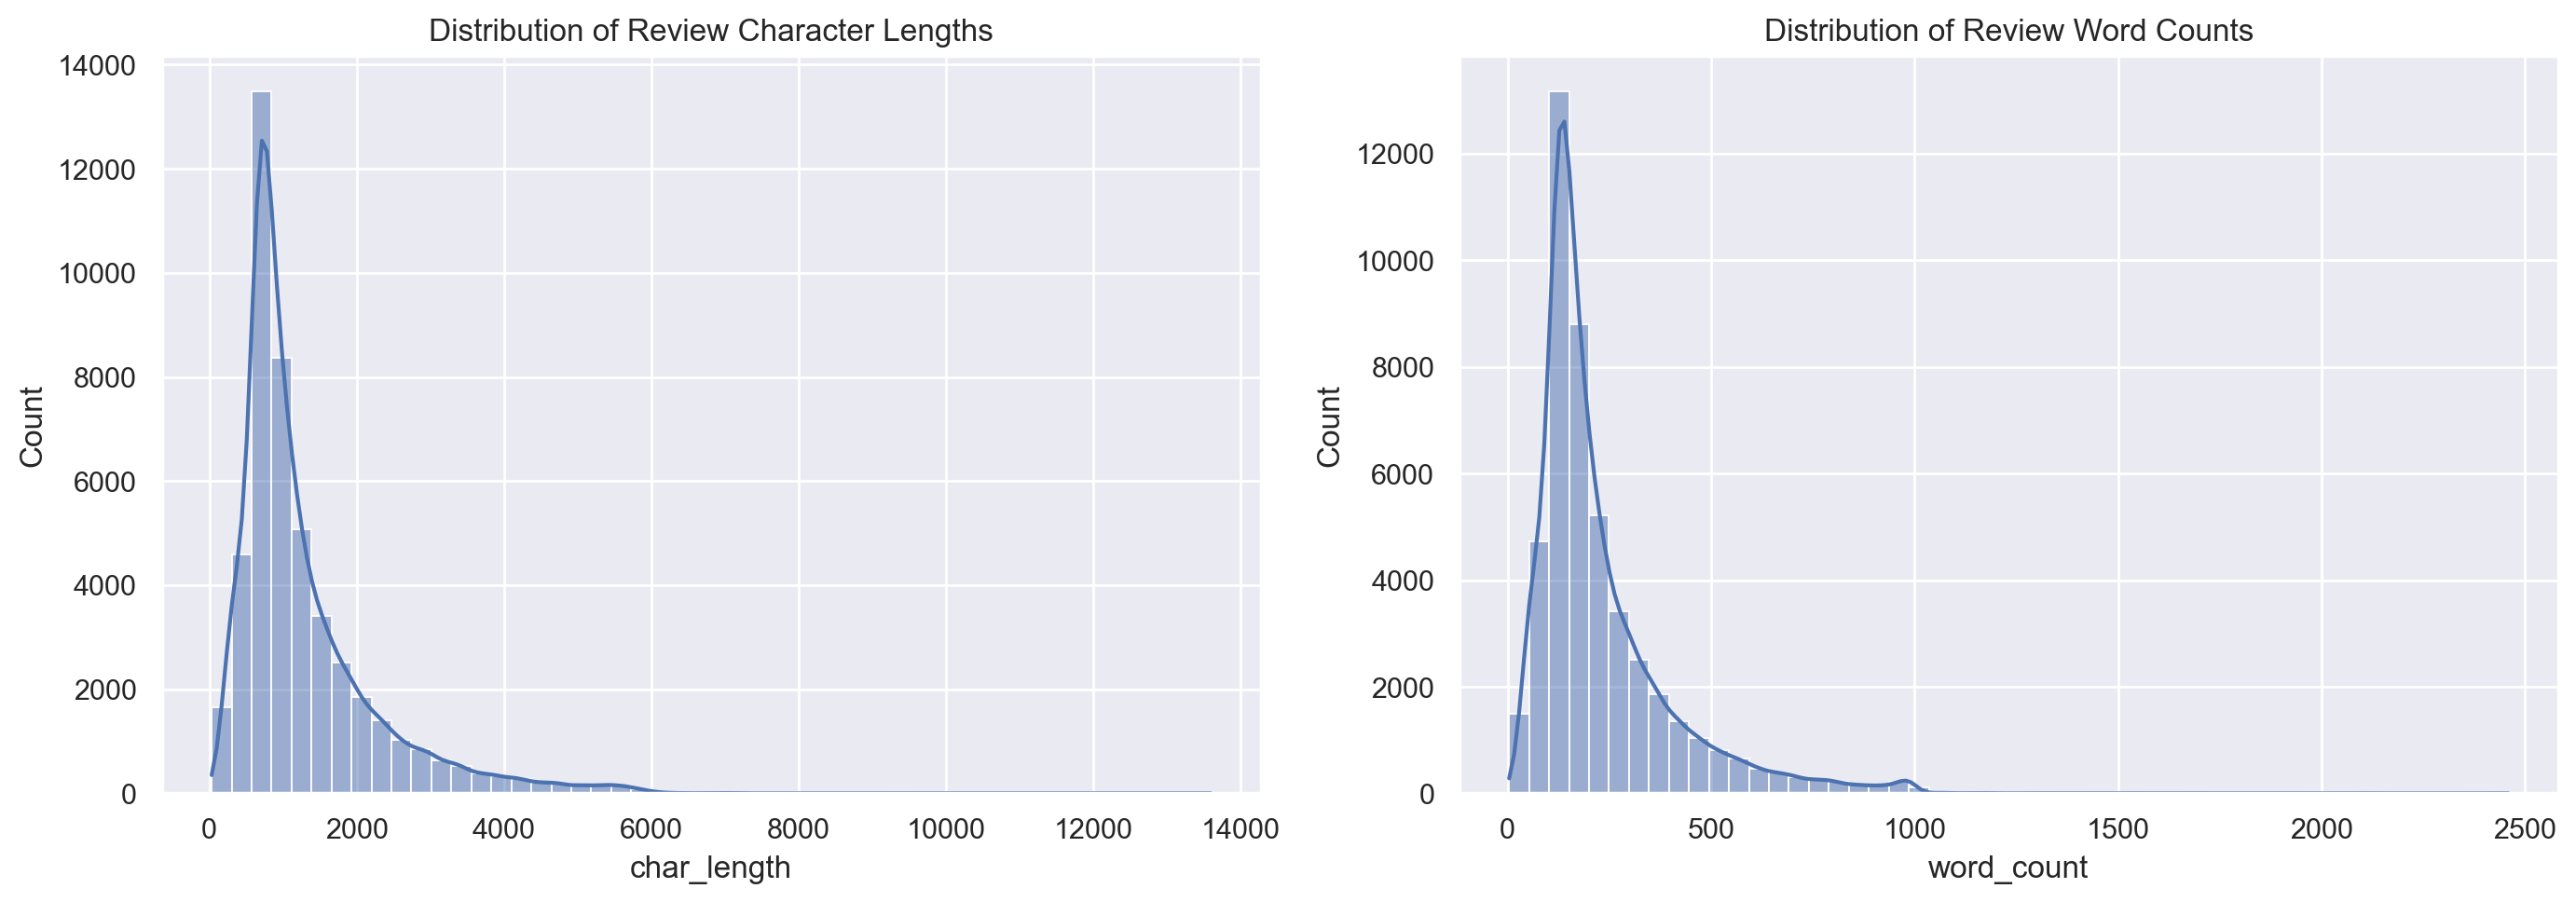

In [8]:
# Exploring the text reviews

df_reviews['char_length'] = df_reviews['review'].apply(len)
df_reviews['word_count'] = df_reviews['review'].apply(lambda x: len(x.split()))


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_reviews['char_length'], bins=50, ax=axs[0], kde=True)
axs[0].set_title('Distribution of Review Character Lengths')

sns.histplot(df_reviews['word_count'], bins=50, ax=axs[1], kde=True)
axs[1].set_title('Distribution of Review Word Counts')

plt.tight_layout()
plt.show()

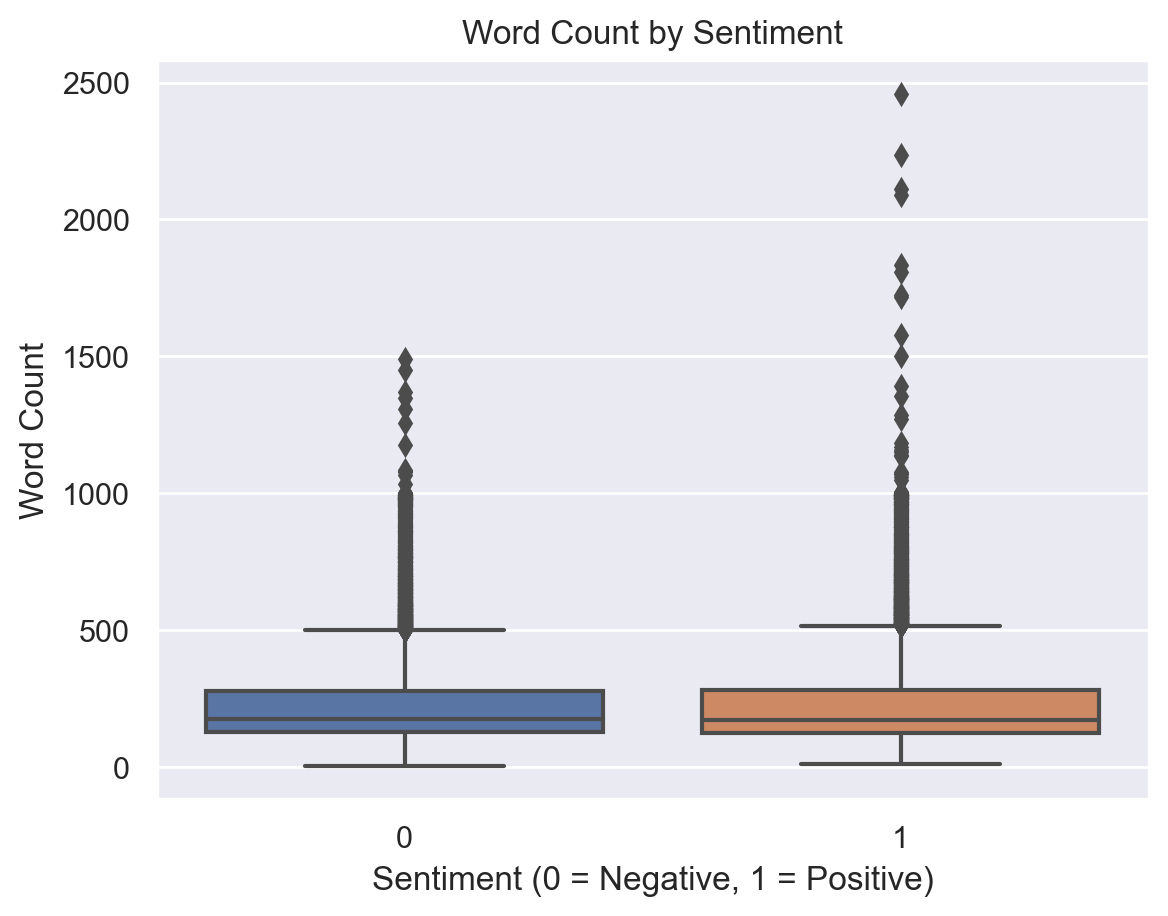

In [9]:
# Compare word count of positive and negative reviews
sns.boxplot(x='pos', y='word_count', data=df_reviews)
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Word Count')
plt.show()

- Review lengths:
Most reviews are under 500 words and under 2000 characters

- By Sentiment:
The median word count is similar between positive and negative reviews. Both classes have similar spread, with few long reviews each.

In [10]:
# Exploring Review Volume per Movie
movie_review_counts = df_reviews['tconst'].value_counts()
movie_review_counts.describe()

count    6648.000000
mean        7.119585
std         7.987691
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        30.000000
Name: count, dtype: float64

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


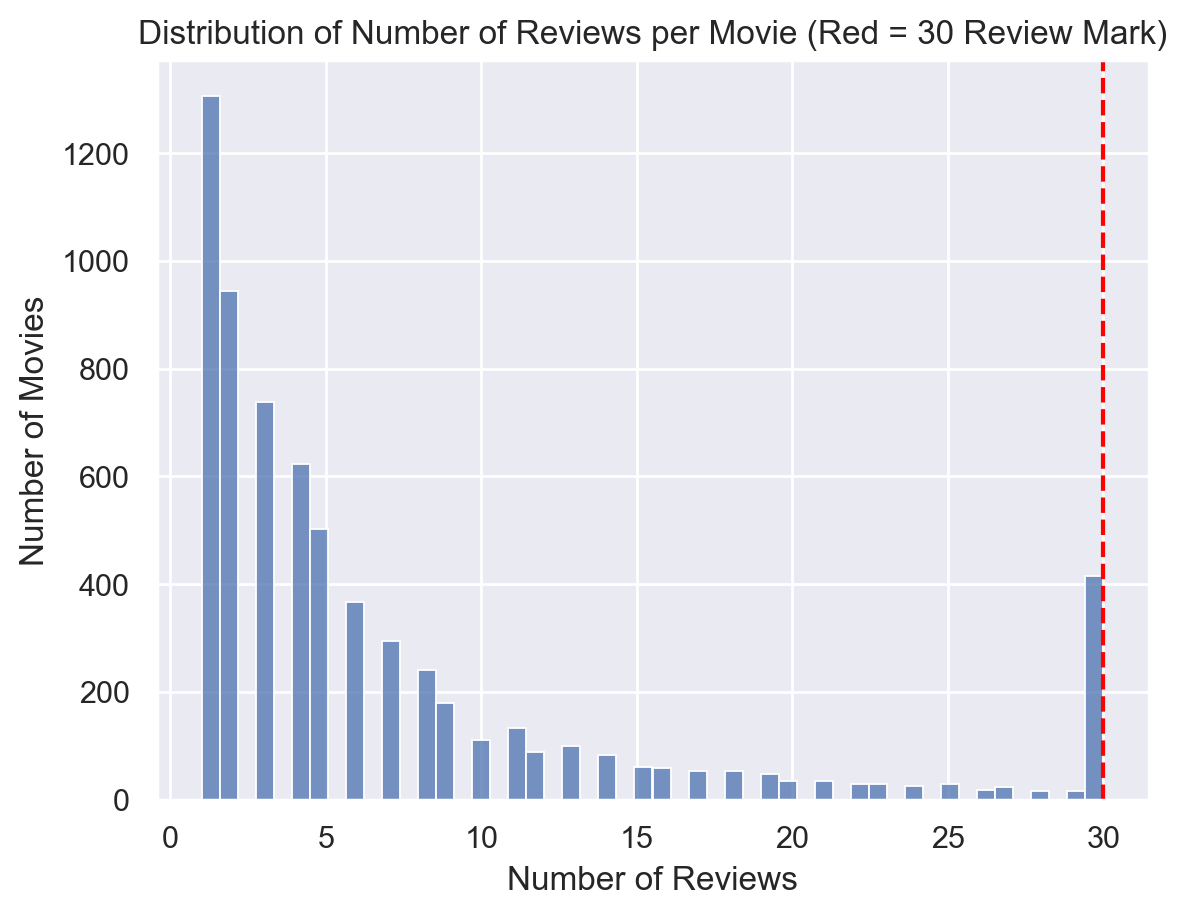

In [11]:
# Distribution with tail clipped
sns.histplot(movie_review_counts, bins=50)
plt.axvline(30, color='red', linestyle='--')
plt.title('Distribution of Number of Reviews per Movie (Red = 30 Review Mark)')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Movies')
plt.show()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

In [12]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return df_eval_stats['test'].to_dict()

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
# Load stopwords as a list (important for TfidfVectorizer)
stop_words = stopwords.words('english')

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words] # Remove stopwords
    return ' '.join(words)

In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use cleaned review text
train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

# TF-IDF Vectorizer
tfidf_nltk = TfidfVectorizer(stop_words=stop_words)

# Convert text into numeric matrices
X_train_tfidf = tfidf_nltk.fit_transform(train_corpus)  # Use this with train_target
X_test_tfidf = tfidf_nltk.transform(test_corpus)        # Use this with test_target

In [18]:
# See the first 20 words (features)
# For older versions of scikit-learn
tfidf_vocab = list(tfidf_nltk.get_feature_names_out()) if hasattr(tfidf_nltk, 'get_feature_names_out') else tfidf_nltk.get_feature_names()

print(tfidf_vocab[:20])
print("Total features:", len(tfidf_vocab))

# Look at first few transformed reviews
tfidf_df = pd.DataFrame(X_train_tfidf[:5].toarray(), columns=tfidf_vocab)
tfidf_df.head()

['aa', 'aaa', 'aaaaaaah', 'aaaaah', 'aaaaatchkah', 'aaaand', 'aaah', 'aaand', 'aaargh', 'aaaugh', 'aachen', 'aada', 'aadha', 'aadmittedly', 'aag', 'aage', 'aaghh', 'aah', 'aahhh', 'aaip']
Total features: 105551


,aa,aaa,aaaaaaah,aaaaah,aaaaatchkah,aaaand,aaah,aaand,aaargh,aaaugh,...,zy,zyada,zyuranger,zz,zzzz,zzzzz,zzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Working with models

In [19]:
model_scores = {}

### Model 0 - Constant

Establishing a benchmark.

In [20]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


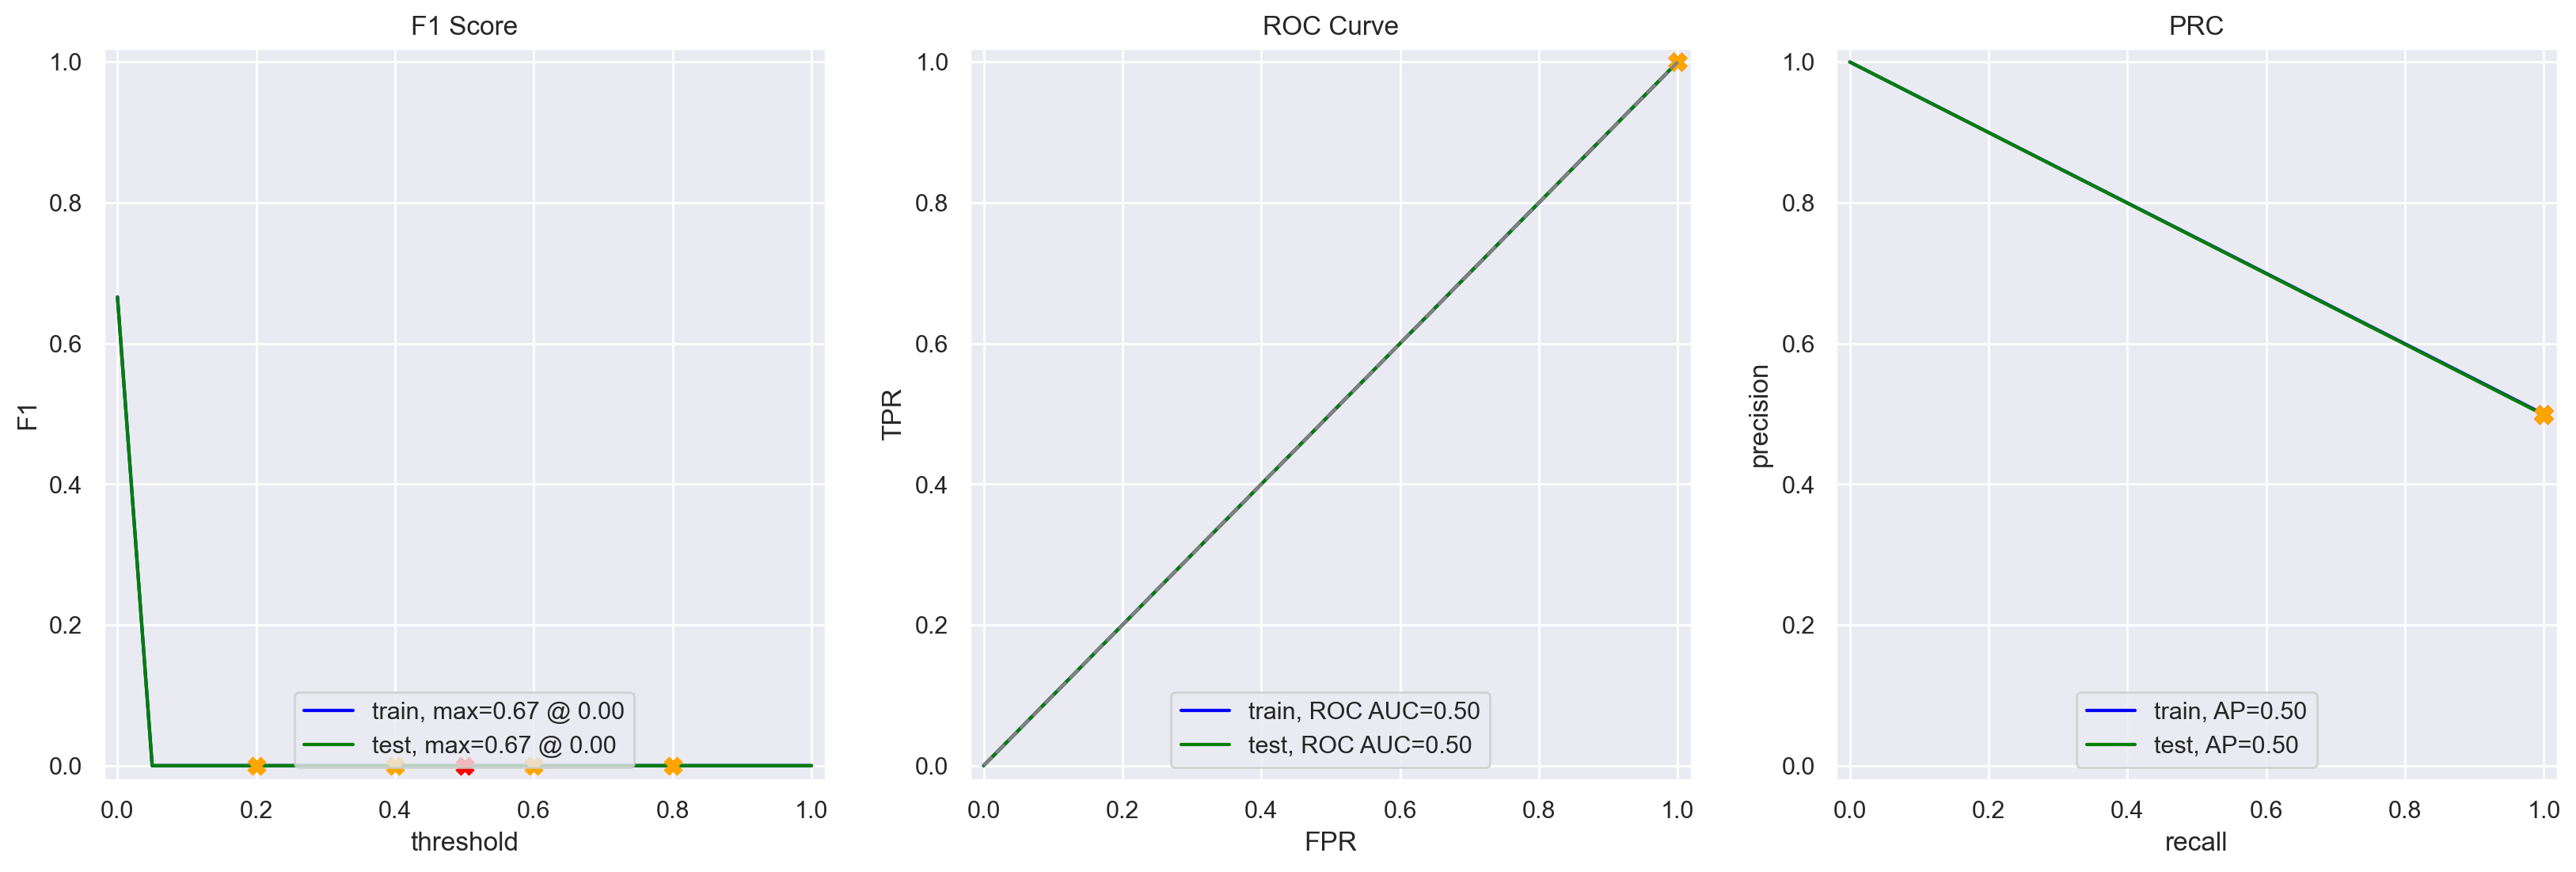

In [21]:
# Initialize and train
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_tfidf, train_target)

# Evaluate
model_scores['Dummy'] = evaluate_model(dummy, X_train_tfidf, train_target, X_test_tfidf, test_target)

### Model 1 - NLTK, TF-IDF and LR

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


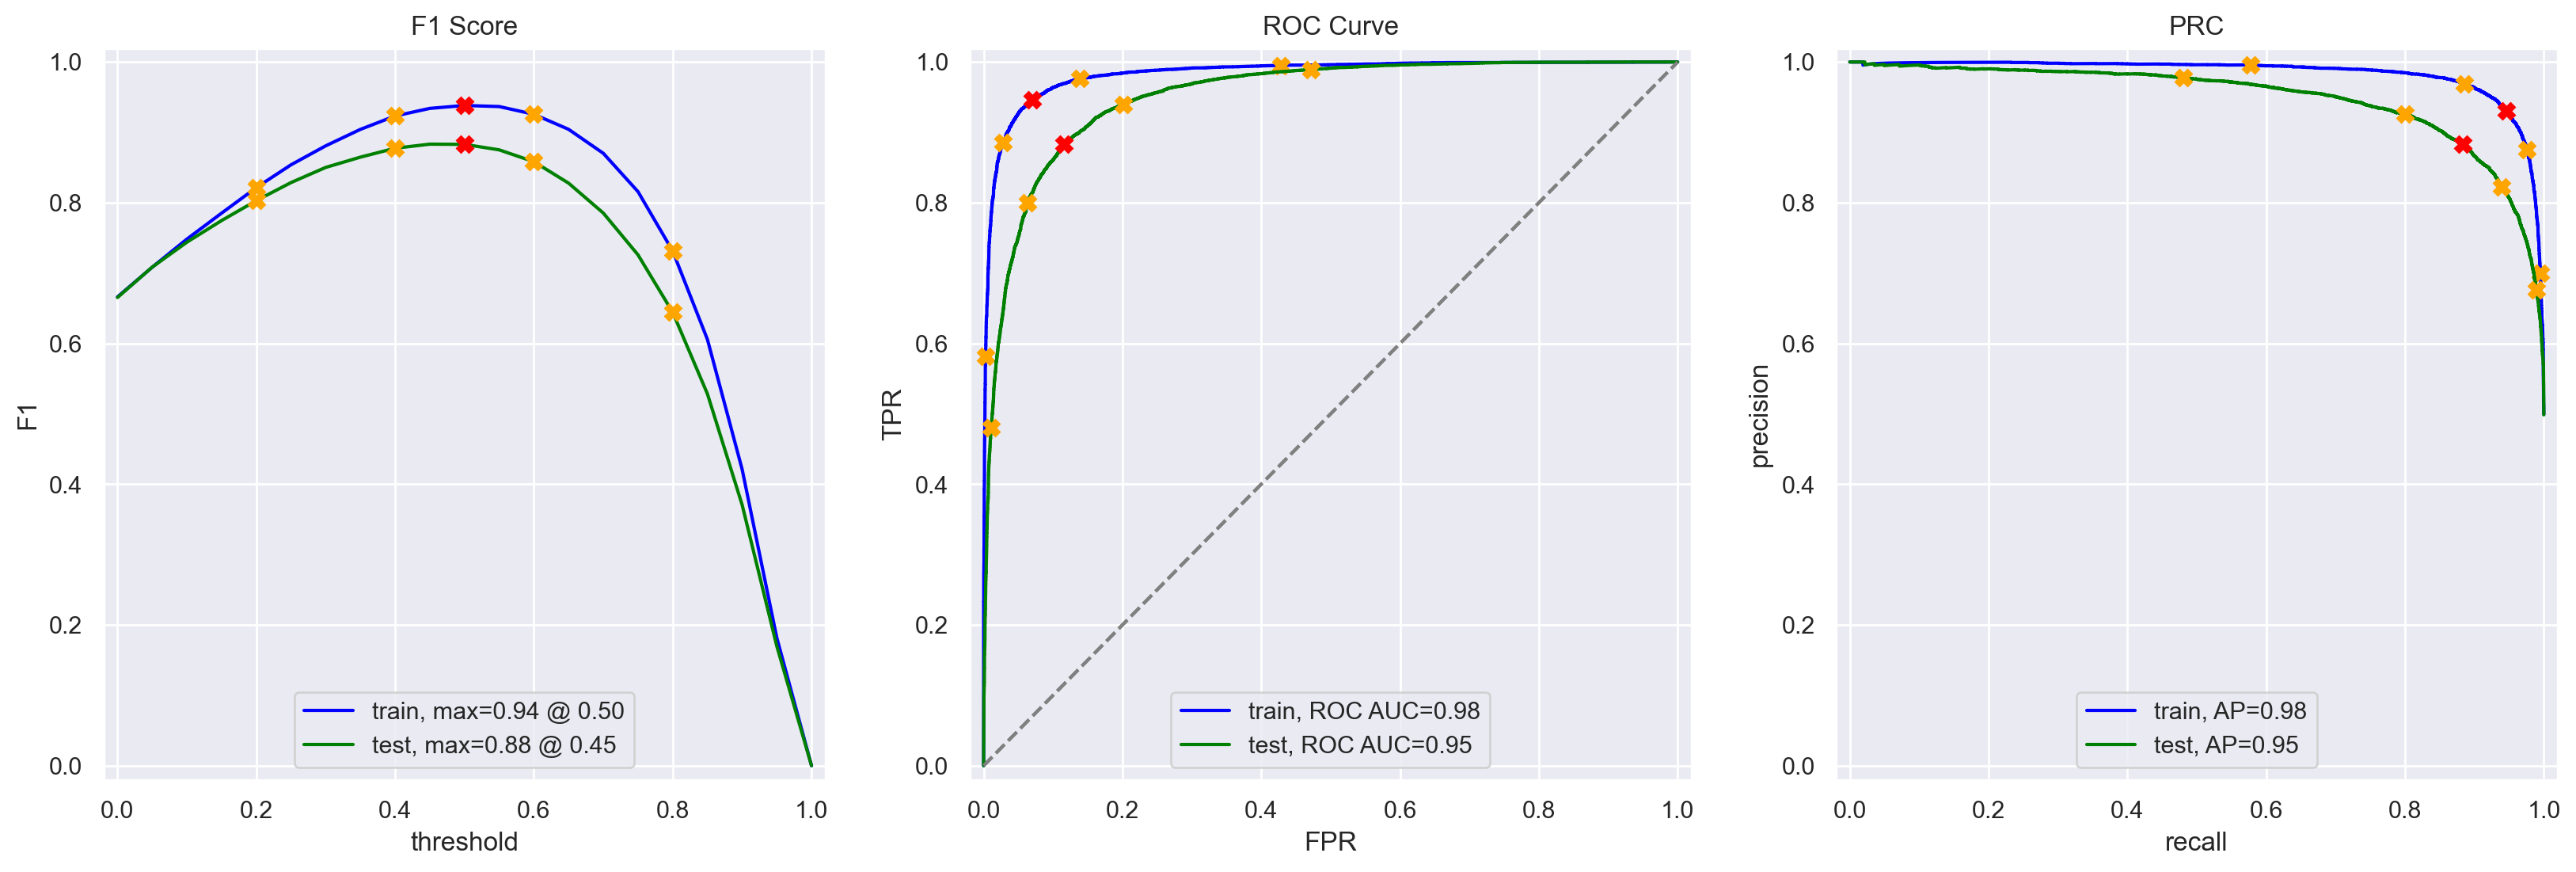

In [22]:
# Initalize model
lr_nltk = LogisticRegression(random_state=42, max_iter=1000)

# Fit
lr_nltk.fit(X_train_tfidf, train_target)

# Evaluate
model_scores['NLTK + TF-IDF + LR'] = evaluate_model(lr_nltk, X_train_tfidf, train_target, X_test_tfidf, test_target)

This model has a high accuracy score and a high F1 score. The ROC curve and Precision-Recall Curve (PRC) charts support that this model confident in its predictions.

Reading the charts:

- The F1 chart shows how the F1 score is impacted by different threshold values for positive predictions. In this case, the highest test F1 score occurred at threshold 0.45, which slightly improves over the default threshold of 0.5.

- The ROC curve shows how well the model separates positive and negative reviews across different threshold values. A curve that hugs the top-left corner indicates strong separation between classes. In this case, the ROC AUC score of 0.95 suggests excellent class discrimination.

- The PRC curve shows how the model balances precision and recall for different thresholds. A high and gradually declining curve means the model maintains high precision even as it tries to capture more positive reviews. The average precision score of 0.95 indicates strong performance, especially for identifying positive sentiment.



### Model 3 - spaCy, TF-IDF and LR

In [23]:
import spacy
!python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.9 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
# def spacy_normalize(text):

#     doc = nlp(text.lower())
#     #tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]

#     return ' '.join(tokens)



# Much faster batch processing with nlp.pipe
def spacy_batch_normalize(texts):
    cleaned_reviews = []
    for doc in nlp.pipe(texts, batch_size=1000):  # Adjust batch_size as needed
        tokens = [token.lemma_ for token in doc
                  if not token.is_stop and not token.is_punct and token.is_alpha]
        cleaned_reviews.append(' '.join(tokens))
    return cleaned_reviews

In [25]:
df_reviews['review_lemma'] = spacy_batch_normalize(df_reviews['review'])

In [26]:
# Re-split after adding 'review_lemma'
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Create new train/test corpora from the lemmatized column
train_lemma_corpus = df_reviews_train['review_lemma']
test_lemma_corpus = df_reviews_test['review_lemma']

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_spacy = TfidfVectorizer(stop_words=stop_words)
X_train_lemma_tfidf = tfidf_spacy.fit_transform(train_lemma_corpus)
X_test_lemma_tfidf = tfidf_spacy.transform(test_lemma_corpus)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


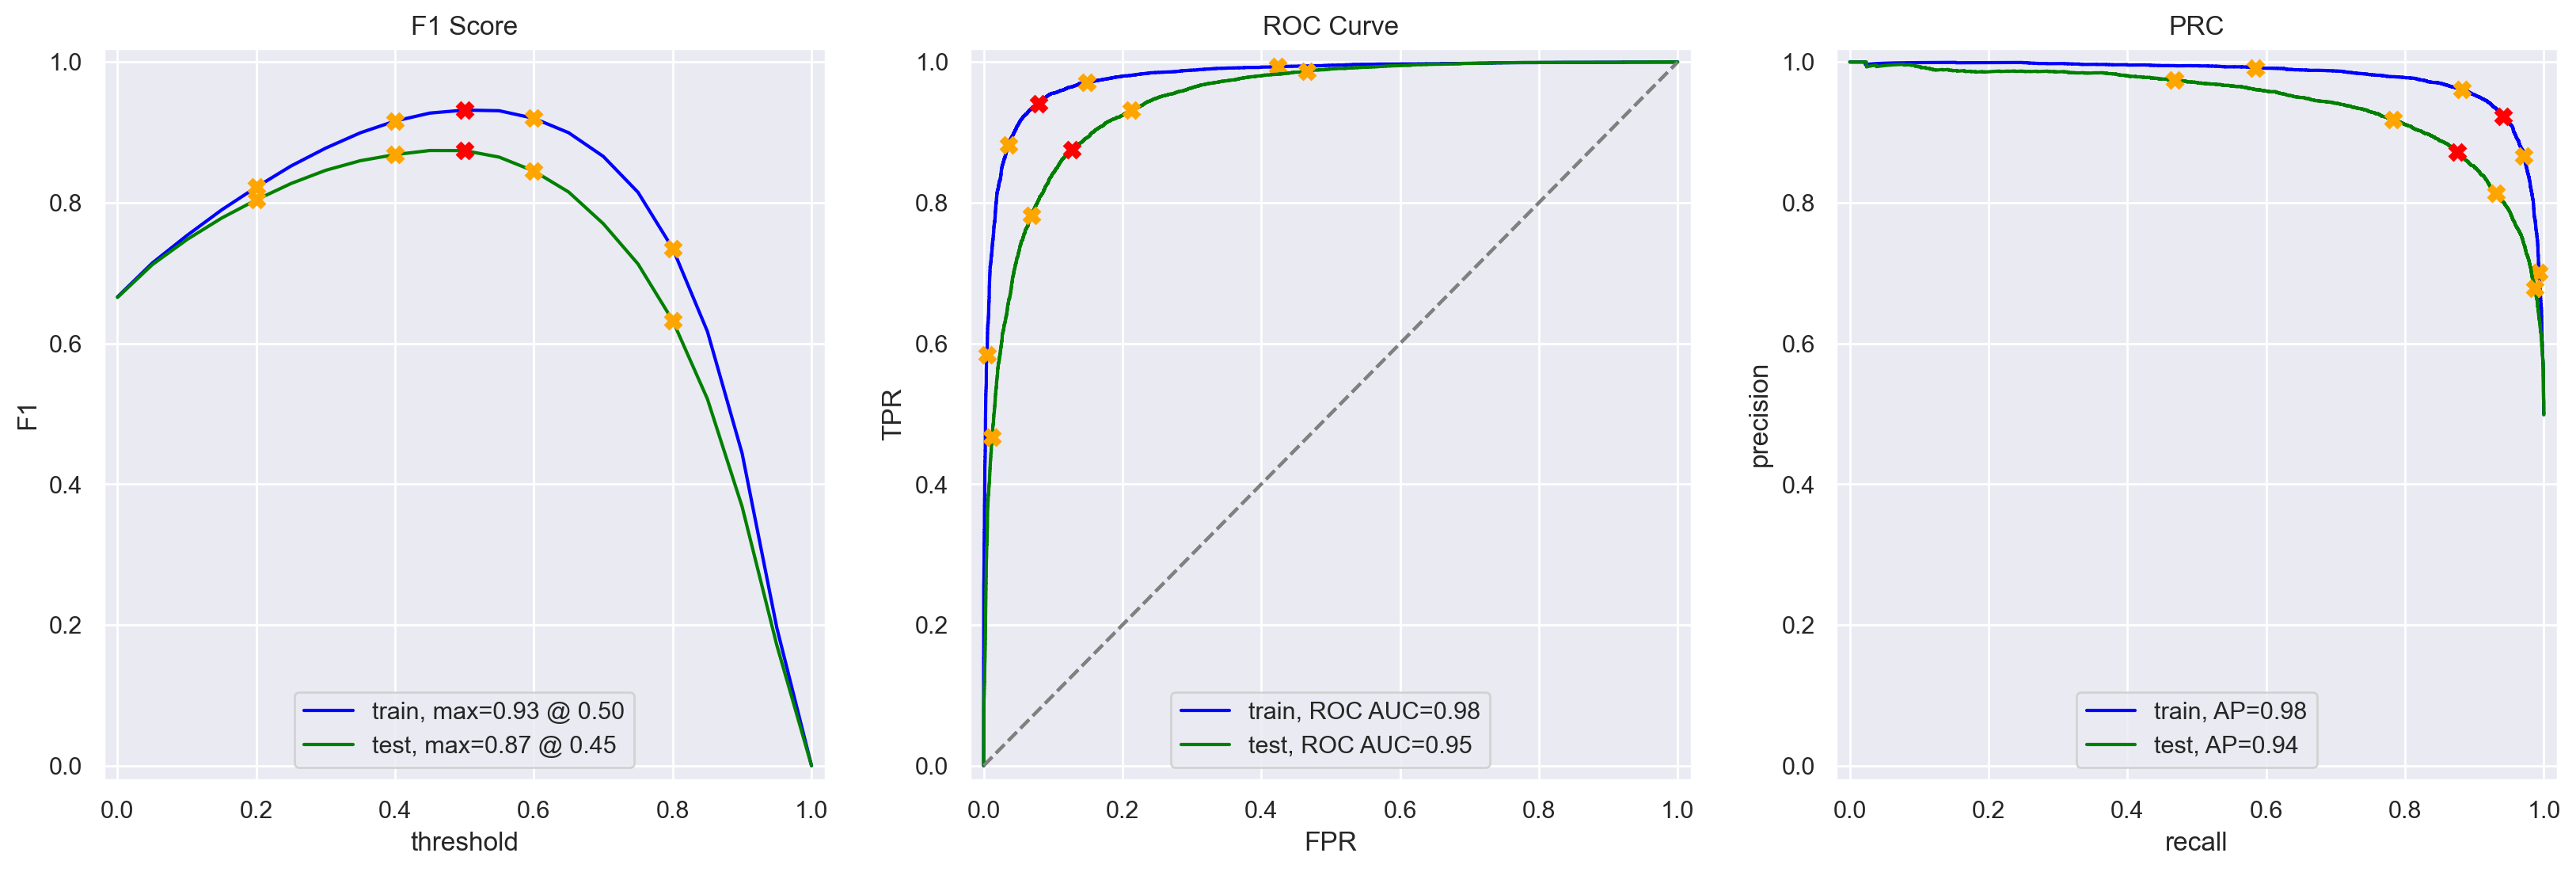

In [28]:
# Train Logistic Regression on spaCy-preprocessed data
lr_spacy = LogisticRegression(random_state=42, max_iter=1000)
lr_spacy.fit(X_train_lemma_tfidf, train_target)

# Evaluate
model_scores['spaCy + TF-IDF + LR'] = evaluate_model(lr_spacy, X_train_lemma_tfidf, train_target, X_test_lemma_tfidf, test_target)

The spaCy + TF-IDF + Logistic Regression model achieved a test F1 score of 0.87, with an ROC AUC of 0.95 and average precision score (APS) of 0.94.

Performance was nearly identical to the NLTK-based model, suggesting that both normalization approaches are effective. Both versions are strong enough to meet the project requirement (F1 ≥ 0.85)

This suggests that lemmatization didn’t hurt performance, and it could even generalize better if I tuned further.


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [30]:
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [-1, 10],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 300]
}


random_search_lgbm = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    scoring='f1',
    n_iter=4,  # try 4 random combinations
    cv=3,
    n_jobs=-1,
    verbose=1
)

random_search_lgbm.fit(X_train_lemma_tfidf, train_target)

print("Best F1 Score:", random_search_lgbm.best_score_)
print("Best Parameters:", random_search_lgbm.best_params_)

best_lgbm = random_search_lgbm.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


python(53580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53636) Malloc

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.370876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427900
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Best F1 Score: 0.8464252871802876
Best Parameters: {'num_leaves': 31, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.1}


          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


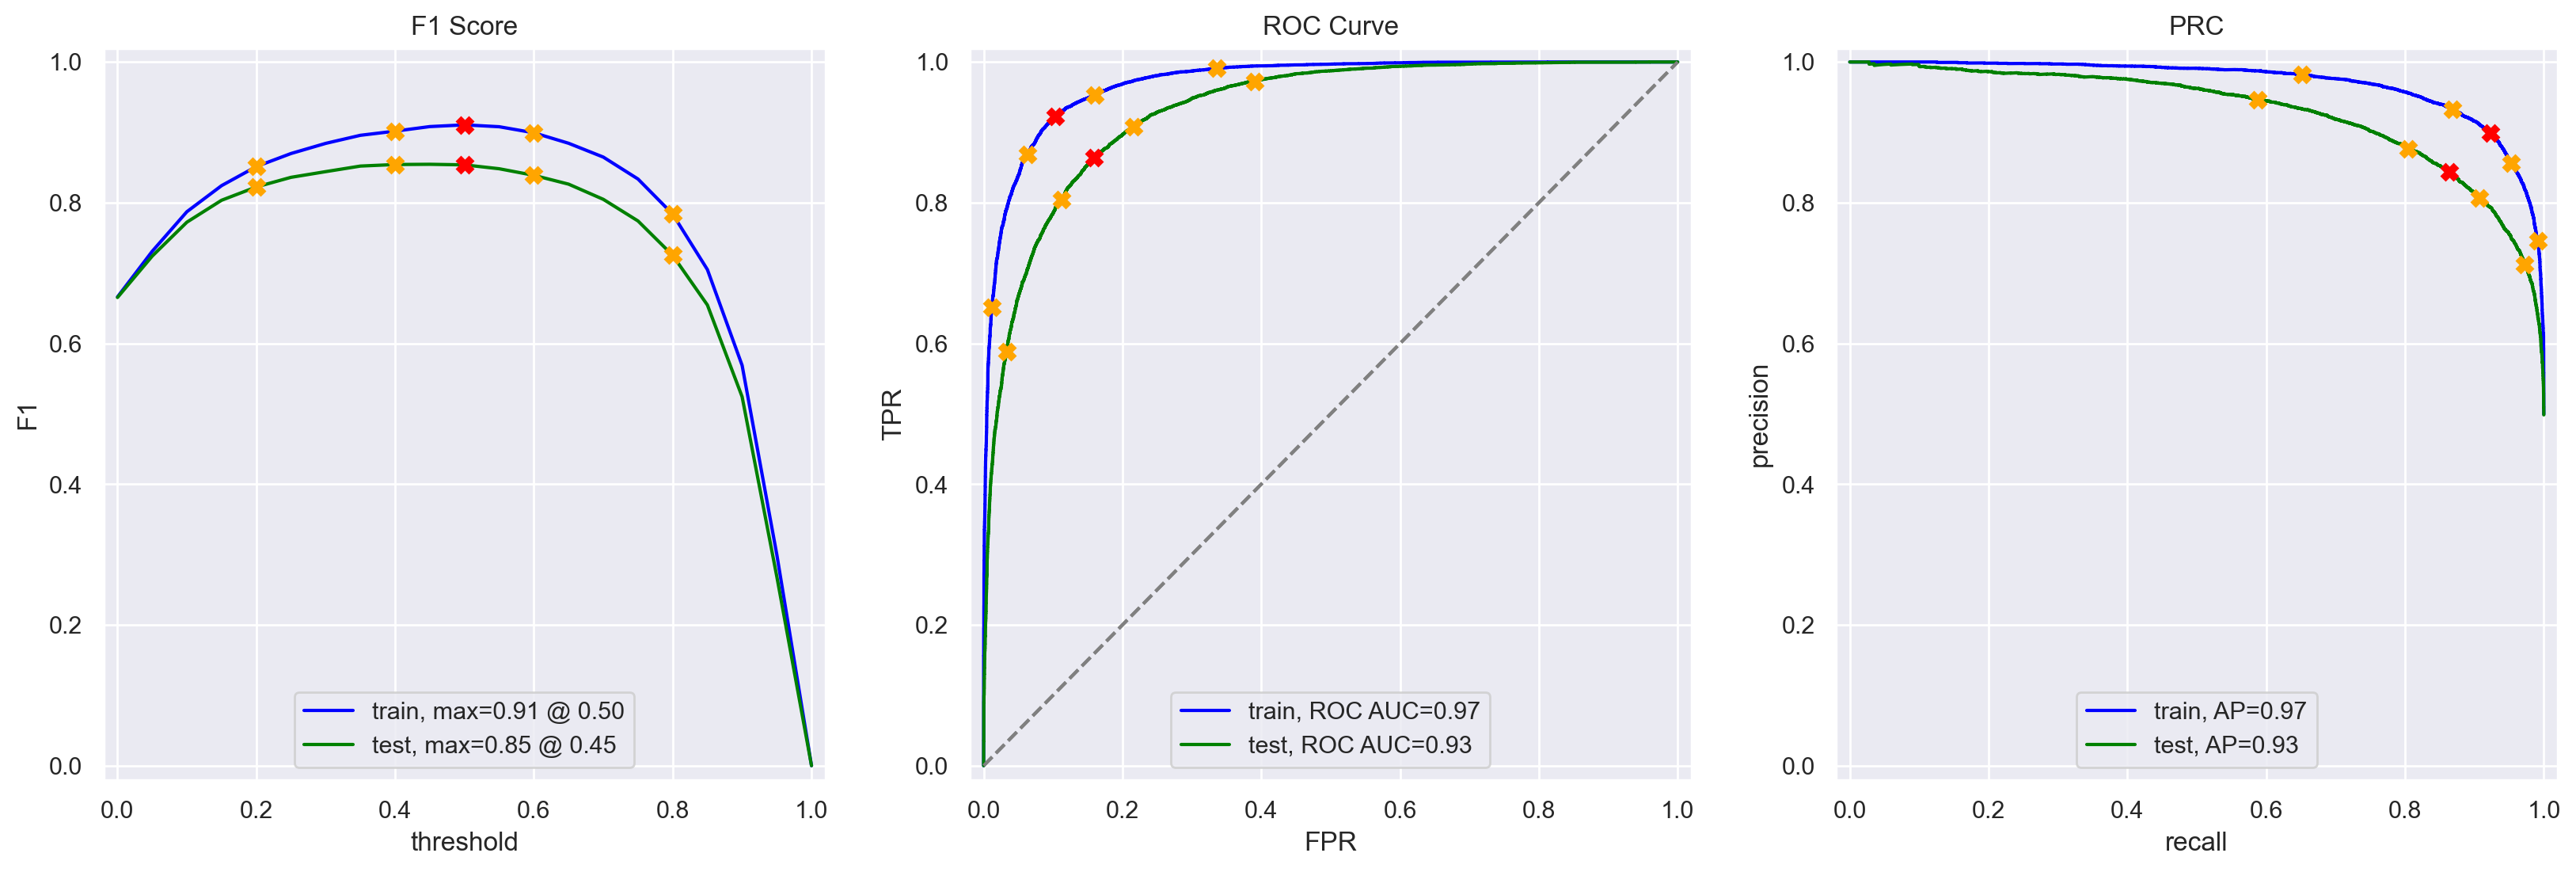

In [31]:
model_scores['spaCy + TF-IDF + LGBM'] = evaluate_model(best_lgbm, X_train_lemma_tfidf, train_target, X_test_lemma_tfidf, test_target)

The LightGBM model trained on spaCy-lemmatized TF-IDF features achieved a test F1 score of 0.87, matching the performance of the logistic regression models. Although its training metrics were near-perfect, the generalization to unseen data was similar, suggesting LightGBM may slightly overfit on this dataset without further regularization.

###  Model 9 - BERT

In [32]:
import torch
import transformers

In [33]:
from sklearn.utils import shuffle

# Reduce size for speed
df_train_bert = df_reviews_train.sample(n=500, random_state=42).copy()
df_test_bert = df_reviews_test.sample(n=500, random_state=42).copy()

In [34]:
# Load the tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/Users/lrw/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
def BERT_text_to_embeddings(texts, max_length=128, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # Tokenize all texts into ids and attention masks
    for text in texts:
      encoded = tokenizer.encode_plus(
          text,
          truncation=True,
          padding='max_length',
          max_length=max_length,
          return_tensors='pt'
          )

      ids_list.append(encoded['input_ids'].squeeze().tolist())
      attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())

    # Choose CPU or GPU
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    # Loop through the batches
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [36]:
# Smaller sample for speed
texts_train = df_reviews_train.sample(n=500, random_state=42)['review'].tolist()
texts_test = df_reviews_test.sample(n=500, random_state=42)['review'].tolist()

X_train_bert = BERT_text_to_embeddings(texts_train)
X_test_bert = BERT_text_to_embeddings(texts_test)

y_train_bert = df_reviews_train.loc[df_reviews_train.index.isin(df_reviews_train.sample(n=500, random_state=42).index), 'pos']
y_test_bert = df_reviews_test.loc[df_reviews_test.index.isin(df_reviews_test.sample(n=500, random_state=42).index), 'pos']

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
print("Train features shape (X_train_bert):", X_train_bert.shape)
print("Train target shape (y_train_bert):", y_train_bert.shape)

print("Test features shape:", X_test_bert.shape)
print("Test target shape:  ", y_test_bert.shape)

Train features shape (X_train_bert): (500, 768)
Train target shape (y_train_bert): (500,)
Test features shape: (500, 768)
Test target shape:   (500,)


          train  test
Accuracy   0.98  0.51
F1         0.98  0.51
APS        1.00  0.52
ROC AUC    1.00  0.52


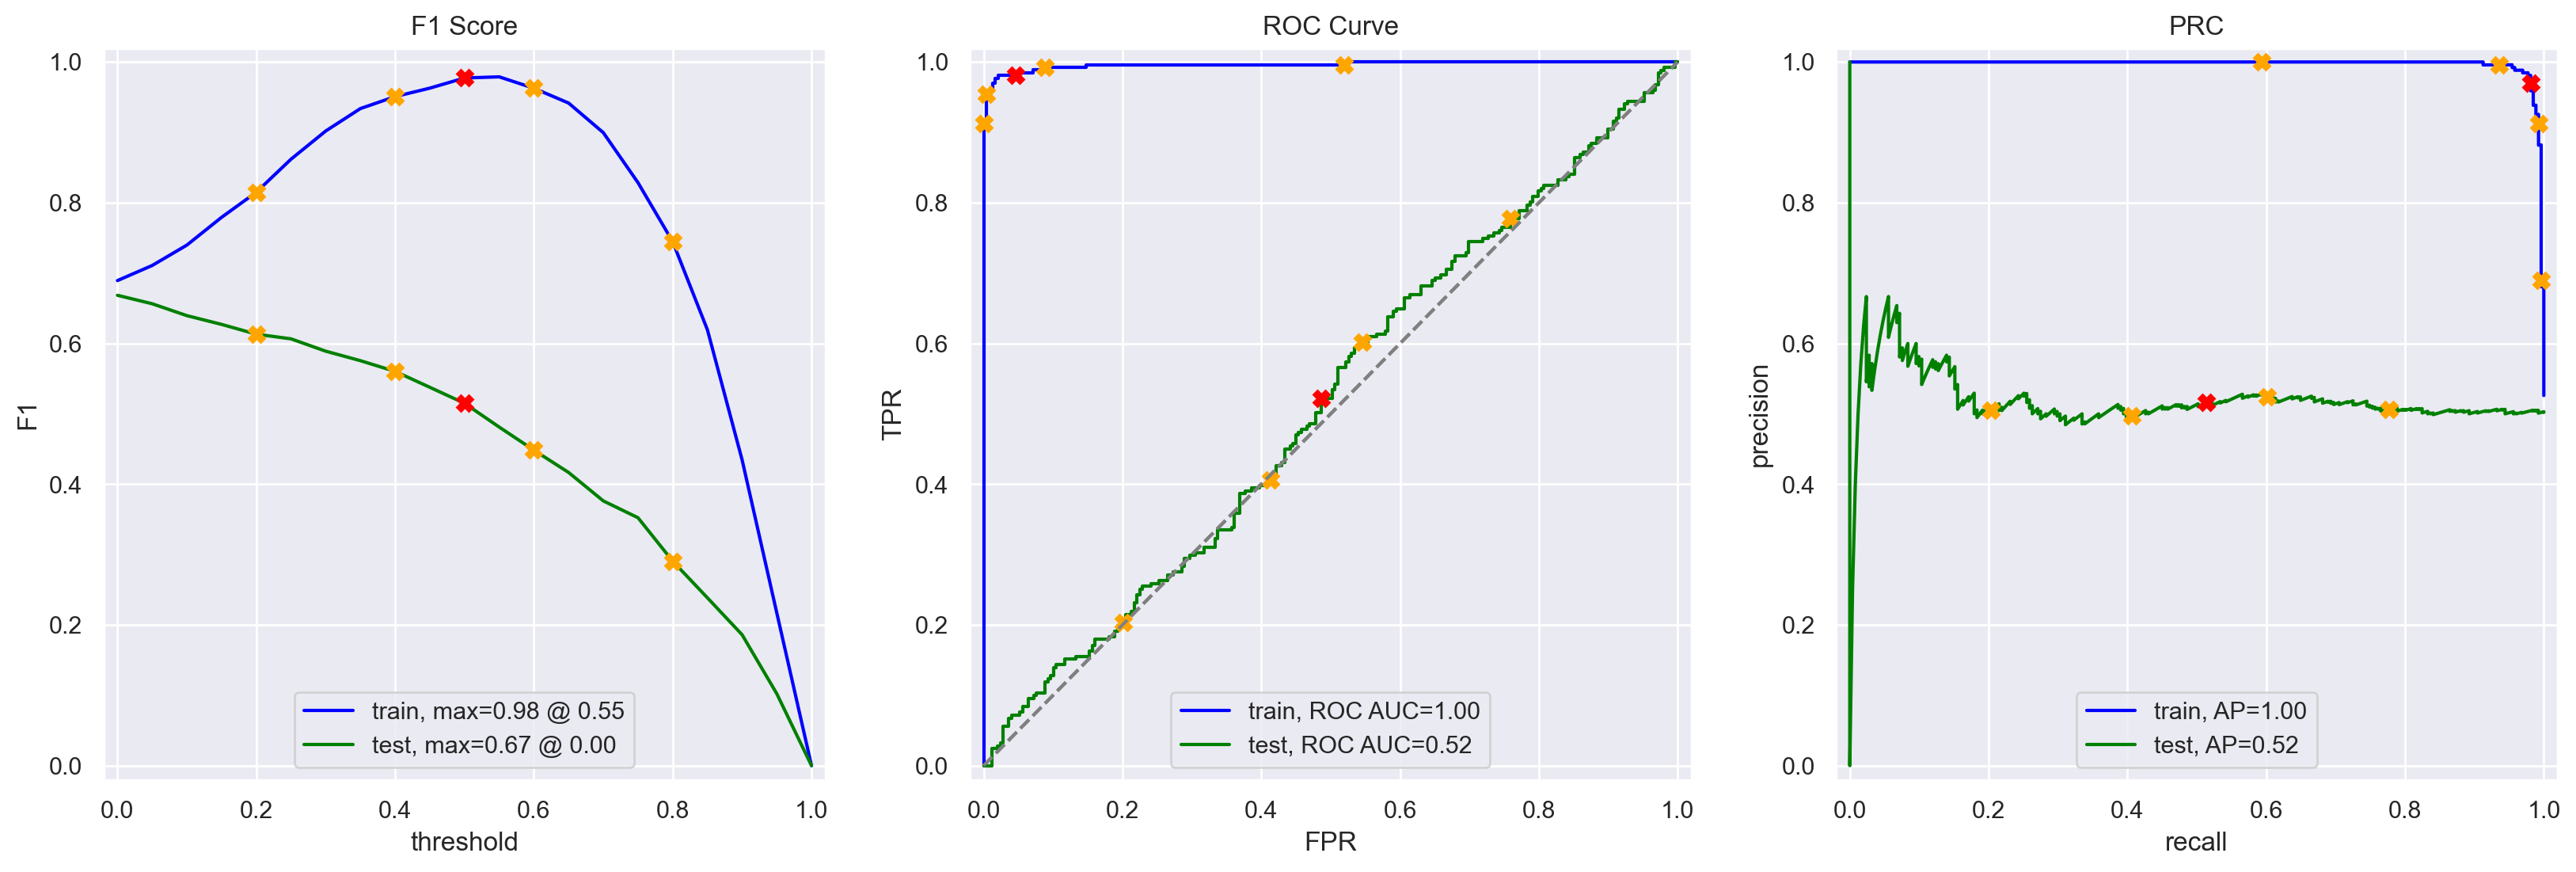

In [38]:
# Apply BERT to logistic regression
bert_lr = LogisticRegression(max_iter=1000, random_state=42)
bert_lr.fit(X_train_bert, y_train_bert)

# Evaluate
model_scores['BERT + LR'] = evaluate_model(bert_lr, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

The Logistic Regression model trained on BERT embeddings achieved perfect training results but performed poorly on the test set, with F1 and ROC AUC scores near random.

This suggests severe overfitting, likely due to the small sample size and the high dimensionality of the BERT feature space.

I think this illustrates a key limitation of using BERT on a small dataset without fine-tuning or dimensionality reduction.

In [39]:
# Save all arrays together in one .npz file
np.savez('bert_embeddings.npz',
         X_train=X_train_bert,
         X_test=X_test_bert,
         y_train=y_train_bert,
         y_test=y_test_bert)

print("BERT embeddings saved to 'bert_embeddings.npz'")

BERT embeddings saved to 'bert_embeddings.npz'


## My Reviews

In [40]:
# Load saved BERT data
data = np.load('bert_embeddings.npz')

X_train_bert = data['X_train']
X_test_bert = data['X_test']
y_train_bert = data['y_train']
y_test_bert = data['y_test']

print(" BERT embeddings loaded.")

 BERT embeddings loaded.


In [41]:
# Sample reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actors looked really old disinterested go...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writers really cared ...
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall dece...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke lands everyo...
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...


## Make Review Predictions with Each Model

### NLTK + TF-IDF + LR

In [42]:
print(my_reviews.columns)

Index(['review', 'review_norm'], dtype='object')


In [43]:
texts = my_reviews['review_norm']
probs_nltk = lr_nltk.predict_proba(tfidf_nltk.transform(texts))[:, 1]

print("NLTK TF-IDF + Logistic Regression Predictions")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{probs_nltk[i]:.2f}:  {review}')

NLTK TF-IDF + Logistic Regression Predictions
0.16:  simply like kind movie
0.17:  well bored felt asleep middle movie
0.57:  really fascinated movie
0.13:  even actors looked really old disinterested got paid movie soulless cash grab
0.26:  didnt expect reboot good writers really cared source material
0.48:  movie upsides downsides feel like overall decent flick could see going see
0.05:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.84:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### spaCy + TF-IDF + Logistic Regression

In [44]:
my_reviews['review_lemma'] = spacy_batch_normalize(my_reviews['review'])

In [45]:
print(my_reviews.columns)
my_reviews['review_lemma'].head()

Index(['review', 'review_norm', 'review_lemma'], dtype='object')


0                               simply like kind movie
1                       bored feel asleep middle movie
2                                      fascinate movie
3    actor look old disinterested get pay movie sou...
4       expect reboot good writer care source material
Name: review_lemma, dtype: object

In [46]:
texts = my_reviews['review_lemma']
probs_spacy_lr = lr_spacy.predict_proba(tfidf_spacy.transform(texts))[:, 1]

print("spaCy TF-IDF + Logistic Regression Predictions")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{probs_spacy_lr[i]:.2f}:  {review}')

spaCy TF-IDF + Logistic Regression Predictions
0.16:  simply like kind movie
0.09:  bored feel asleep middle movie
0.62:  fascinate movie
0.16:  actor look old disinterested get pay movie soulless cash grab
0.24:  expect reboot good writer care source material
0.40:  movie upside downside feel like overall decent flick go
0.02:  rotten attempt comedy single joke land act annoying loud kid will like
0.90:  launch Netflix brave appreciate able binge episode episode exciting intelligent new drama


### spaCy, TF-IDF and LGBMClassifier

In [47]:
lgbm_spacy = best_lgbm

In [48]:
texts = my_reviews['review_lemma']
probs_spacy_lgbm = lgbm_spacy.predict_proba(tfidf_spacy.transform(texts))[:, 1]

print("spaCy TF-IDF + LGBM Predictions")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{probs_spacy_lgbm[i]:.2f}:  {review}')

spaCy TF-IDF + LGBM Predictions
0.56:  simply like kind movie
0.41:  bored feel asleep middle movie
0.58:  fascinate movie
0.34:  actor look old disinterested get pay movie soulless cash grab
0.60:  expect reboot good writer care source material
0.56:  movie upside downside feel like overall decent flick go
0.27:  rotten attempt comedy single joke land act annoying loud kid will like
0.77:  launch Netflix brave appreciate able binge episode episode exciting intelligent new drama


### BERT

In [49]:
# Create embeddings for custom reviews
bert_review_embeddings = BERT_text_to_embeddings(my_reviews['review'], disable_progress_bar=True)

# Use the trained model from earlier
probs_bert = bert_lr.predict_proba(bert_review_embeddings)[:, 1]


print("BERT + Logistic Regression Predictions")
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{probs_bert[i]:.2f}:  {review}')

BERT + Logistic Regression Predictions
0.61:  I did not simply like it, not my kind of movie.
0.31:  Well, I was bored and felt asleep in the middle of the movie.
0.21:  I was really fascinated with the movie
0.81:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.41:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.51:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.19:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.76:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


## Conclusions

The objective of this project was to build a model that can classify movie reviews as positive or negative. The target metric was an F1 score ≥ 0.85, and we tested multiple approaches ranging from simple baselines to context-aware BERT embeddings.


### Model Performance Comparison


Overall, TF-IDF models performed very well and were efficient to train. BERT was promising, but the limited training sample led to overfitting. With more data or fine-tuning, BERT could outperform simpler models, but for this project, the classic models were more stable and effective.


In [50]:
# Compare results from the models
comparison_df = pd.DataFrame(model_scores).T.round(2)

display(comparison_df)

,Accuracy,F1,APS,ROC AUC
Dummy,0.50,0.00,0.50,0.50
NLTK + TF-IDF + LR,0.88,0.88,0.95,0.95
spaCy + TF-IDF + LR,0.87,0.87,0.94,0.95
spaCy + TF-IDF + LGBM,0.85,0.85,0.93,0.93
BERT + LR,0.51,0.51,0.52,0.52


### Model Predictions on Custom Reviews

To better understand how each model behaves in practice, we created a set of 8 hand-written reviews covering a mix of sentiments — including clear positive/negative tones and more ambiguous phrasing.

Below is a comparison of predicted probabilities for the positive class:


Key observations:
- BERT showed more variability than TF-IDF models, predicting unexpectedly high scores for some negative reviews (rows 0 & 3).
- spaCy + LGBM was slightly more confident overall and more likely to push scores closer to 0 or 1.
- TF-IDF + Logistic Regression models gave consistent, interpretable results, making them highly effective for this task.

What's interesting is that while spaCy + LR confidently predicted a negative sentiment (0.09), BERT and LGBM hovered closer to neutrality, suggesting they were less certain. This may reflect the more subtle or ambiguous language in the review — e.g., 'bored' is clear, but 'fell asleep' might not be as emotionally charged."

These review-level results helped validate the models' real-world behavior beyond their overall metrics — especially useful for selecting the most reliable model in production settings.

In [51]:
# Compare results of the My Reviews
custom_review_df = pd.DataFrame({
    'review': my_reviews['review'],
    'NLTK + LR': probs_nltk,
    'spaCy + LR': probs_spacy_lr,
    'spaCy + LGBM': probs_spacy_lgbm,
    'BERT + LR': probs_bert
})
custom_review_df['review_short'] = custom_review_df['review'].str.slice(0, 80)
custom_review_df = custom_review_df[['review_short', 'NLTK + LR', 'spaCy + LR', 'spaCy + LGBM', 'BERT + LR']]

display(custom_review_df)

,review_short,NLTK + LR,spaCy + LR,spaCy + LGBM,BERT + LR
0,"I did not simply like it, not my kind of movie.",0.160129,0.163775,0.564681,0.610988
1,"Well, I was bored and felt asleep in the middl...",0.173287,0.090856,0.406231,0.312894
2,I was really fascinated with the movie,0.565922,0.617594,0.582371,0.206474
3,Even the actors looked really old and disinter...,0.126244,0.164102,0.342703,0.812843
4,I didn't expect the reboot to be so good! Writ...,0.258154,0.237856,0.604863,0.411699
5,"The movie had its upsides and downsides, but I...",0.478044,0.396876,0.557432,0.506805
6,What a rotten attempt at a comedy. Not a singl...,0.046294,0.024014,0.274067,0.188790
7,Launching on Netflix was a brave move & I real...,0.844077,0.899937,0.765486,0.761463


[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.238794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310031
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Info] Number of positive: 7922, number of negative: 7942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.082972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301328
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7017
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499370 -> initscore=-0.00252

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.214536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308957
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7175
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Info] Number of positive: 7922, number of negative: 7942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.272808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301328
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7017
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499370 -> initscore=-0.002521
[LightGBM] [Info] Start training from score -0.002521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.251832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310031
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

### Recommendation

The NLTK + TF-IDF + Logistic Regression seems to be the best-performing model overall.

- It achieved a high test F1 Score (0.88) - very close to the benchmark (0.85)
- It produced consistent results across multiple types of reviews, with a clear distinction between positive and negative sentiments. This makes it a great option for a more interpretable and stable model.
- This model is also quick to train and easy to implement without requiring massive computational resources.
- TD-IDF does a good job at extracting sentiment words.